In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/ELEC542-TextGuidedRecolorization


In [2]:
import os 
import pickle as pkl

In [6]:
src_path = os.path.join('./data/hexcolor_vf/train_names.pkl')
with open(src_path, 'rb') as f:
    names = pkl.load(f)

print("Loading %s palette names..." % len(names))
print("Making text dictionary...")

Loading 9165 palette names...
Making text dictionary...


In [8]:
names[:10]

[['it', 'is', 'cold'],
 ['gloomy', 'blue'],
 ['ugly'],
 ['screaming', 'into', 'the', 'void'],
 ['green'],
 ['grape', 'to', 'strawberry'],
 ['fresh', 'squeezed', 'orange', 'juice'],
 ['depression', 'days'],
 ['shoot'],
 ['day', 'in', 'the', 'rainforest']]

In [9]:
with open('./data/hexcolor_vf/train_palettes_rgb.pkl', 'rb') as f:
    pals = pkl.load(f)

pals[:4]

[[(86, 131, 192),
  (151, 221, 209),
  (128, 109, 212),
  (160, 208, 218),
  (191, 167, 229)],
 [(57, 89, 118), (73, 112, 135), (27, 99, 135), (34, 77, 109), (28, 56, 77)],
 [(111, 46, 46), (62, 89, 163), (99, 78, 46), (81, 88, 23), (56, 50, 53)],
 [(134, 156, 165), (140, 118, 159), (90, 57, 114), (49, 17, 81), (43, 5, 41)]]

In [25]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_palette(palette: list, name:str = None):
    '''
    Take a list of 5 RGB colors defined as (R, G, B) in the range [0, 255]
    and plot them as a horizontal bar of squares.
    '''
    palette = np.array(palette) / 255.0
    plt.figure(figsize=(8, 2))
    plt.imshow([palette], aspect='auto')
    plt.axis('off')
    if name:
        plt.title(name)
    plt.show()

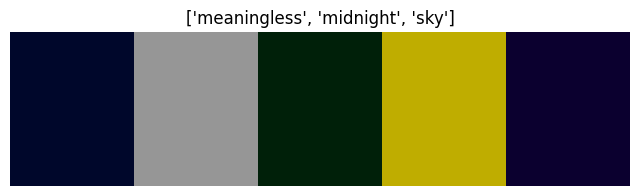

In [31]:
idx = np.random.randint(len(pals))  # get a random index
visualize_palette(pals[idx], names[idx])  # visualize first palette

# Palette to Color Dataset (P2C)

In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/ConceptGuidedColorization


In [3]:
import numpy as np
import os 
import pickle as pkl
from skimage.color import rgb2lab

In [78]:
data_path_imgs = "data/bird256/test_palette/test_images_origin.txt"
data_path_palettes = "data/bird256/test_palette/test_palette_origin.txt"

In [79]:
with open(data_path_imgs, 'rb') as f:
    imgs = pkl.load(f)


In [80]:
with open(data_path_palettes, 'rb') as f:
    pals = pkl.load(f)

In [81]:
type(imgs)

list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06594693..0.3211516].


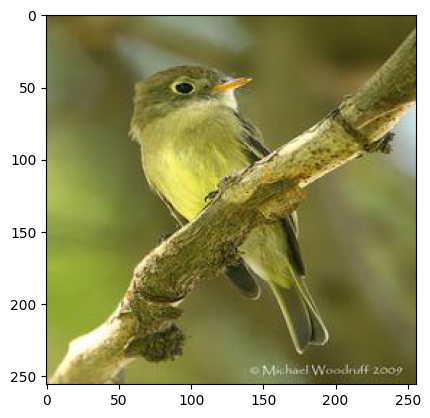

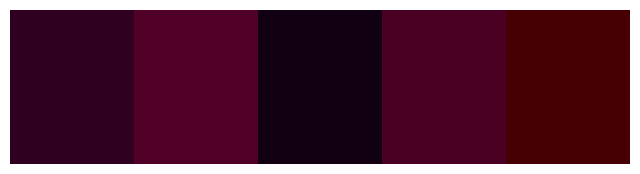

In [126]:
import matplotlib.pyplot as plt

IDX = np.random.randint(len(imgs))

plt.imshow(imgs[IDX].transpose(1, 2, 0) / 255)
_pal = rgb2lab(np.asarray(pals[IDX]  / 256).reshape(5, 3))

visualize_palette(_pal)

In [ ]:
import torch
def process_palette_ab(pal_data, batch_size):

    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_ab_scale = np.concatenate((img_a_scale,img_b_scale),axis=2)
    ab_for_global = torch.from_numpy(img_ab_scale).float()
    ab_for_global = ab_for_global.view(batch_size, 10).unsqueeze(2).unsqueeze(2)

    return ab_for_global

def process_palette_lab(pal_data, batch_size):

    img_l = pal_data[:, :, 0:1] / 100
    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_lab_scale = np.concatenate((img_l, img_a_scale, img_b_scale),axis=2)
    lab_for_global = torch.from_numpy(img_lab_scale).float()
    lab_for_global = lab_for_global.view(batch_size, 15).unsqueeze(2).unsqueeze(2)

    return lab_for_global

def process_data(image_data, batch_size, imsize):
    input = torch.zeros(batch_size, 1, imsize, imsize)
    labels = torch.zeros(batch_size, 2, imsize, imsize)
    images_np = image_data.numpy().transpose((0, 2, 3, 1))

    for k in range(batch_size):

        img_lab = rgb2lab(images_np[k], illuminant='D50')
        img_l = img_lab[:, :,0] / 100
        input[k] = torch.from_numpy(np.expand_dims(img_l, 0))

        img_a_scale = (img_lab[:, :, 1:2] + 88) / 185
        img_b_scale = (img_lab[:, :, 2:3] + 127) / 212

        img_ab_scale = np.concatenate((img_a_scale,img_b_scale),axis=2)
        labels[k] = torch.from_numpy(img_ab_scale.transpose((2, 0, 1)))

    return input, labels